# AlphaZero version 3

This model is based on AlphaZero version 2 and trained further on 1.000.000 training examples from the StageOne dataset on a 5x4 board.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random

import LineFilterLayer

baseModelPath = 'model/alphaZeroV2.h5'
modelPath = 'model/alphaZeroV3.h5'

Using TensorFlow backend.


In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [4]:
rawDataset = np.load('stageOne5x4.npz')
x_train = rawDataset['x_train']
y_train = rawDataset['y_train']
x_train_cat = dotsAndBoxesToCategorical(x_train)
y_train_cat = dotsAndBoxesToCategorical(y_train)

np.set_printoptions(precision=2)

print("original data:")
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)

print("\nnormalized data:")
print(np.transpose(x_train_cat[0]))
print(np.transpose(y_train_cat[0]))
print(x_train_cat.shape)
print(y_train_cat.shape)

original data:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0 255   0   0   0   0   0 255   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0   0   0 255   0   0   0   0   0 255   0   0   0]
 [  0 215   0 215   0 215 255 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0 255   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215 255 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0

In [5]:
LineFilterLayer.LineFilterLayer.imgWidth = x_train.shape[-1]
LineFilterLayer.LineFilterLayer.imgHeight = x_train.shape[-2]
model = load_model(baseModelPath, custom_objects={'LineFilterLayer':LineFilterLayer.LineFilterLayer})

LineFilterLayer from_config!
using static image size 13 x 11
Tensor("Const:0", shape=(11, 13), dtype=bool)


In [6]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat

lineFilterMatrixNP(x_train.shape[-1],x_train.shape[-2])

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True,

In [7]:
y_train_lines = y_train[:,lineFilterMatrixNP(y_train.shape[-1], y_train.shape[-2])]
print(y_train_lines.shape)
print(y_train_lines[0])

(1000000, 49)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 5 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, None, None, 6 8064        input_2[0][0]                    
__________________________________________________________________________________________________
input_relu (Activation)         (None, None, None, 6 0           input_conv[0][0]                 
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, None, 6 256         input_relu[0][0]                 
__________________________________________________________________________________________________
res1_conv1

In [9]:
#sess = K.get_session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

# Training
callbacks = []

checkpoint = ModelCheckpoint(filepath=modelPath+".checkpoint", save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

tensorboard = TensorBoard(log_dir='model/log3', write_grads=True, write_graph=True, write_images=True, histogram_freq=1)
#callbacks.append(tensorboard)

model.fit(x_train_cat, y_train_lines, epochs=16, batch_size=64, callbacks=callbacks, validation_split=0.001)

model.save(modelPath)

Train on 999000 samples, validate on 1000 samples
Epoch 1/16
Epoch 1/16
999000/999000 [==============================] - 712s 713us/step - loss: 661.1976 - val_loss: 661.4458
Epoch 2/16
Epoch 2/16
999000/999000 [==============================] - 683s 683us/step - loss: 659.9344 - val_loss: 659.6477
Epoch 3/16
Epoch 3/16
999000/999000 [==============================] - 673s 674us/step - loss: 659.3969 - val_loss: 659.2856
Epoch 4/16
Epoch 4/16
999000/999000 [==============================] - 671s 672us/step - loss: 658.9477 - val_loss: 661.3644
Epoch 5/16
Epoch 5/16
999000/999000 [==============================] - 692s 693us/step - loss: 658.7094 - val_loss: 658.8287
Epoch 6/16
Epoch 6/16
999000/999000 [==============================] - 700s 700us/step - loss: 658.4489 - val_loss: 659.7352
Epoch 7/16
Epoch 7/16
222976/999000 [=====>........................] - ETA: 9:17 - loss: 658.5419

KeyboardInterrupt: 

In [10]:
model.save(modelPath)

In [11]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

example: 241144
[[  0   0   0   0   0   0   0   0   0   0   0 100   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]]
1.0
input (11, 13): 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0 255   0 255   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215 255 215   0 215 255 215   0]
 [  0   0   0   0   0 255   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0 255   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]
prediction: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 

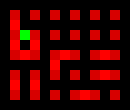

In [12]:
example = random.randrange(x_train.shape[0])
print("example: "+str(example))

input_data = x_train[example:example+1]
input_data_cat = x_train_cat[example:example+1]

prediction_lines = model.predict(input_data_cat)
prediction_lines_print = prediction_lines * 100
print(prediction_lines_print.astype(np.uint8))
print(np.sum(prediction_lines))
prediction = linesToDotsAndBoxesImage(prediction_lines[0], x_train.shape[2], x_train.shape[1])

# print input data
input_data_print = x_train[example,:,:] 
input_data_print = input_data_print.astype(np.uint8)
print("input "+str(input_data_print.shape)+": ")
print(input_data_print)

# generate greyscale image data from input data
target_imgdata = x_train[example,:,:] 
target_imgdata = target_imgdata.astype(np.uint8)

# print prediction
prediction_data_print = prediction * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction: ")
print(prediction_data_print)

# generate greyscale image data from prediction data
prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros((prediction.shape[0], prediction.shape[1]), dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata, tmp], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img